# Attributable heatwaves paper: development script

### step 1: find present day warming in models

find present day warming window in models

- pick present-day warming window from literature target, step 3 option 2 (*) 
- look at observations (ERA5 or other) to validate models. Look regionally? Cold bias over Europe cfr to obs?
- for step 3 option 1 select only models that are within +/- 0.2 deg C of observed GMST warming. 


To do: this is now in another script, make a function and move it there to automate everything

### step 2: calculate pre-industrial TX99 (p0)

calculate grid cell percentiles from ISIMIP3b historical tasmax data from a baseline period 1850-1900, get baseline thresholds (p0, Xth)

note. alternative heat metrics 
- TX99 pi probability of exceedance is 0.01 by definition (p0 = Xthreshold) (*)
- HWMId
- 3dTX>90p with p90 from mid-20th century (e.g. 1960-1980)

note. possibilities to define p0
1) hist 1850-1900 (*)
2) hist-nat 1850-1900
3) present-day hist-nat (1970-2020?)

### step 3: calculate probability of TX99 threshold exceedance in present-day in models (p1)

1) a world that has warmed to today's levels (30-year average warming AR6 method 1.15 deg C wrt 1850-1900, Forster 2023), historical + ssp3-rcp7, window from modeleval output (*)
2) present day years (2001-2020), after model evaluation

To do: check this definition of present-day warming is ok 

### step 4: calculate number of attributable events 

n_attr = n_days (p1-p0)

note. alternative possibilities
1) hist present-day warming vs. hist 1850-1900 (*)
2) hist present-day warming vs. hist-nat same time-window

### step 5: combine with demographic data  


## Next steps 

step 5, aggregate model results mean/median as best estimate. 

step 6, aggregate with observations to attribute observed events
- possibility: normal distribution shift fit at each grid cell on observations based on Hauser's shift fit code
- note: if I work on 3dTX90 (incl. to attribute observed heatwaves start from this), from obs to then get p1 in present-day and use this when I move to model world - and determine ToE as when PR>2 and count number of heatwaves that have occurred after this date


## Extensions
- extend to other metrics (e.g. heatwave-like definitions 3dTX > 90th percentile defined in warm season rolling window or statically) and pick most suitable
- repeat analysis with more models, more CMIP models
- attribute observed events
- accumulate number of "attributable heatwaves" over lifetimes of soemone born in 1850, 1960, 2020 (ages of plaintiffs, or do this for all cohorts like Luke did, to have this database accessible! would be useful!!) - extending to future using different warming pathways
- calculate delta-I (if from shift-fit method this should be simple linear function of location parameters !!)
- scientific evaluation of influence of shape of tail / spread of distribution and does this invalidate results
- bootstrapping for uncertainty ?
- model evaluation / weighting 

Different metrics:
- Make rolling avg 3dTX and calc quantile for that
- accumulated metrics based on this (lifetime accumulated metrics?)
- Calc Perkins-Kirkpatrick heatwave metric (maybe crop data over just Europe to make computations go faster) and other metrics they use
- calc HWMId (maybe use R package??) and calc quantile for that  

Extensions/Alternatives:
- warm season heatwave (climatological percentile)
- fit to a GEV and calc PR in GEV-way, for more extreme values than this (see Li 2021 did this, results are in AR6)
- shift fit observations to normal or other distribution

last update November 2023
rosa.pietroiusti@vub.be

In [59]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), openpyxl

import numpy as np
import pandas as pd
import os, glob, re 
import math
import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import dask
import matplotlib.pyplot as plt
try:
    import netCDF4
except: # for running in env-geosci lite 
   pass

%matplotlib inline
# import my variables settings functions from other scripts
from settings import *
start_message()

from functions import *
from utils import * 

# can turn flags into a class??
# use object oriented a little more?

flags: {'models': 'ISIMIP3b', 'metric': 'TX99', 'method': 'percentile', 'var': 'tasmax'}
indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/
indir: none
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0']
datasets: none
lat_chunk: 90
lon_chunk: 120
time_chunk: -1
outdirs: /data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output
figdirs: /data/brussel/vo/000/bvo00012/vsc10419/attr-hw/figures
start_pi: 1850
end_pi: 1900
observed_warming_path: ../../data/gmst/gmst-obs/forster2023/decadal_averages.csv
dir_gmst_models: ../../data/gmst/gmst-models-isimip3b


In [2]:
from dask.distributed import Client 
client = Client()
client

/apps/brussel/RL8/broadwell/software/dask/2022.10.0-foss-2022a/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36611 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:36611/status,
Dashboard: http://127.0.0.1:36611/status,Workers: 2
Total threads: 2,Total memory: 16.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45371,Workers: 2
Dashboard: http://127.0.0.1:36611/status,Total threads: 2
Started: Just now,Total memory: 16.80 GiB
Comm: tcp://127.0.0.1:33659,Total threads: 1
Dashboard: http://127.0.0.1:34543/status,Memory: 8.40 GiB
Nanny: tcp://127.0.0.1:41915,



## 1. find present day warming window in models 



In [3]:
df_gmst = merge_model_gmst(GCMs, dir_gmst_models)
df_gmst

# extra not necessary in main

IndexError: list index out of range

In [ ]:
df_pd_warming = calc_warming_periods_models(GCMs, dir_gmst_models, observed_warming_path, target_year=2023, method='ar6', windowsize=30)
df_pd_warming


In [ ]:
GCM = GCMs[0]

# not necessary in main

In [ ]:
df_pd_warming.loc[GCM].start_y

# not necessary in main

In [ ]:
calc_warming_periods_models(GCM, dir_gmst_models, observed_warming_path, target_year=2023, method='ar6', windowsize=30).loc[GCM].start_y

# not necessary in main

## 2. open data and calc pre-industrial TX99 (p0=0.01)

In [8]:
outdir = make_outdir(GCM, makedirs=False)
outdir

'/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_dec23/TX99/ISIMIP3b/CanESM5'

In [9]:
dir1, dir2 = get_dirpaths(GCM, 'historical', 'ssp370')
print(dir1,'\n',dir2)

# not necessary in main

/data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/historical/CanESM5 
 /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/ssp370/CanESM5


In [10]:
get_filepaths(var, dir1, dir2=dir2)

# not necessary in main

['/data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/historical/CanESM5/canesm5_r1i1p1f1_w5e5_historical_tasmax_global_daily_1850_1850.nc',
 '/data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/historical/CanESM5/canesm5_r1i1p1f1_w5e5_historical_tasmax_global_daily_1851_1860.nc',
 '/data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/historical/CanESM5/canesm5_r1i1p1f1_w5e5_historical_tasmax_global_daily_1861_1870.nc',
 '/data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/historical/CanESM5/canesm5_r1i1p1f1_w5e5_historical_tasmax_global_daily_1871_1880.nc',
 '/data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/historical/CanESM5/can

In [11]:
da_pres = open_model_data(GCM, period='target-year', scenario1='historical', scenario2='ssp370', target_year=2023, windowsize=4) # in real version windowsize=30 (default value)
da_pres

target year: 2023 warming target: 1.146362745
 OK, number of days in your data array (1461) matches what you would expect between year 2005 and 2008 (1461)


<xarray.DataArray 'tasmax' (time: 1461, lat: 360, lon: 720)>
dask.array<getitem, shape=(1461, 360, 720), dtype=float32, chunksize=(1461, 90, 120), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * time     (time) datetime64[ns] 2005-01-01 2005-01-02 ... 2008-12-31
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Maximum Near-Surface Air Temperature
    units:          K

In [12]:
da_pi = open_model_data(GCM, period='pre-industrial', scenario1='historical', scenario2='ssp370')
da_pi

 OK, number of days in your data array (18627) matches what you would expect between year 1850 and 1900 (18627)


<xarray.DataArray 'tasmax' (time: 18627, lat: 360, lon: 720)>
dask.array<rechunk-merge, shape=(18627, 360, 720), dtype=float32, chunksize=(18627, 90, 120), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * time     (time) datetime64[ns] 1850-01-01 1850-01-02 ... 1900-12-31
Attributes:
    standard_name:  air_temperature
    long_name:      Daily Maximum Near-Surface Air Temperature
    units:          K

In [13]:
data_pres_99 = compute_quantile(da_pres, .99)
data_pres_99

# not necessary in main (?) unless i want to save this to plot delta_i / PR 

<xarray.DataArray 'tasmax' (lat: 360, lon: 720)>
dask.array<getitem, shape=(360, 720), dtype=float64, chunksize=(90, 120), chunktype=numpy.ndarray>
Coordinates:
  * lon       (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat       (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
    quantile  float64 0.99
Attributes:
    start_date:  2005
    end_date:    2008

In [14]:
#data_pres_99.plot()

# not necessary in main

In [15]:
data_pi_99 = compute_quantile(da_pi, .99)
data_pi_99

<xarray.DataArray 'tasmax' (lat: 360, lon: 720)>
dask.array<getitem, shape=(360, 720), dtype=float64, chunksize=(90, 120), chunktype=numpy.ndarray>
Coordinates:
  * lon       (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat       (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
    quantile  float64 0.99
Attributes:
    start_date:  1850
    end_date:    1900

In [16]:
#data_pi_99.plot()

## 3. Calculate probability in present day (p1) and number of attributable hot days in present-day (1 year)

In [17]:
# percentiles_pres_da = calc_percentiles_da(da_pres, data_pi_99)

# not really necessary in main ? unless i want to save. heavy to run


In [18]:
#p_pi = 0.01
#p_pd = 1 - percentiles_pres_da
#n_attr_days = 365 * (p_pd - p_pi)

#da_nAHD = calc_nAHD(GCM, da_pres, da_pi, quantile=.99)

# slow to run

'/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_dec23-8736300/TX99/ISIMIP3b/CanESM5/canesm5_r1i1p1f1_w5e5_historical_tasmax_global_daily_nAHD_piTX99_1992_2021.nc'

In [5]:
# temp save just for a sec 

#da_nAHD.to_netcdf('da_nAHD_2023_temp.nc') # not the real calculation !! Only from 4 years !

#da_nAHD.name = 'number of days'
#da_nAHD
# not necessary in main

# test open one of the real ones 
GCM = GCMs[0]
ncfile = glob.glob(f'/data/brussel/vo/000/bvo00012/vsc10419/attr-hw/output/output_dec23-8736300/TX99/ISIMIP3b/{GCM}/*nAHD*')[0]
da_nAHD = xr.open_dataarray(ncfile) 
da_nAHD

<xarray.DataArray 'number of days' (lat: 360, lon: 720)>
[259200 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
Attributes:
    model:            CanESM5
    start_date_ref:   1850
    end_date_ref:     1900
    start_date_pres:  1992
    end_date_pres:    2021

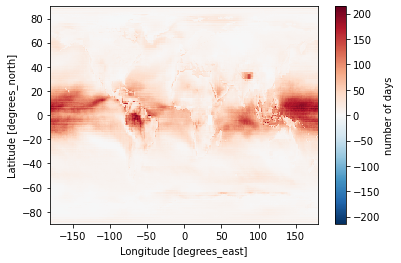

In [6]:
da_nAHD.plot()

# not necessary in main

## 4. Get demographic data for one year, all age ranges

To do 
- make it a module to easily import
- update demogrpahic data used, make it possible to change the input and do some data cleaning in the functions 
- change file saving path get it out of pkg_dir and into work_dir 

In [7]:
sys.path.append('../population/') # make this a module i can pip install and import ! 
from population_demographics_climate import * # move / rename this when good ! 

In [8]:
d_countries = preprocess_all_country_population_data()

interpolating cohort sizes per country
after interpolation and mean-preserving correction there are some neg numbers in 10, Azerbaijan, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 98, Libya, setting them to zero
after interpolation and mean-preserving correction there are some neg numbers in 136, Papua New Guinea, setting them to zero
Aruba small, population not calculated
Antigua and Barbuda small, population not calculated
Bahrain small, population not calculated
Barbados small, population not calculated
Federated States of Micronesia small, population not calculated
Grenada small, population not calculated
Guam small, population not calculated
Saint Lucia small, population not calculated
Macao small, population not calculated
Maldives small, population not calculated
Malta small, population not calculated
Singapore small, population not calculated
Tonga small, population not calculated


In [9]:
gs_population_global = get_gridscale_population_global( 
    d_countries,
    startyear=2022, 
    endyear=None, # just 2022
    save=False # change filesave path 
)

calculating gridscale population per country
processing country 191 of 191
elapsed time 1.7772321701049805
combining gridscale population globally
processing country 191 of 191
elapsed time 75.47269940376282


In [10]:
gs_population_global

<xarray.DataArray 'number of people' (time: 1, lat: 277, lon: 698, ages: 105)>
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
...
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]])
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 -55.25 -54.75 -54.25 -53.75 ... 81.75 82.25 82.75
  * time     (time) int64 2022
  * ages     (ages) int64 0 1 2 3 4 5 6 7 8 ... 96 97 98 99 100 101 102 103 104

In [11]:
gs_population_global.sum()

<xarray.DataArray 'number of people' ()>
array(7.27267342e+09)

## 5. NEW FROM HERE: divide in 10 year ranges and multiply with nAHD for bar plot [REMAKE WITH INTERVALS FROM MODEL SPREAD & OUTPUT KEY VALUES]

to do:
- insert these in function docs and plotscript docs


### v1. divide in 10-year groups before

In [68]:
# Define age ranges (0-9, 10-19, ...)
age_ranges = np.arange(0, 105, 10)
age_ranges


array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100])

In [69]:
# Group the data by age ranges and calculate the sum
grouped_data = gs_population_global.groupby_bins('ages', age_ranges, right=False).sum()
grouped_data


<xarray.DataArray 'number of people' (time: 1, lat: 277, lon: 698, ages_bins: 10)>
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
...
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]]])
Coordinates:
  * lon        (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat        (lat) float64 -55.25 -54.75 -54.25 -53.75 ... 81.75 82.25 82.75
  * time       (time) int64 2022
  * ages_bins  (ages_bins) object [0, 10) [10, 20) ... [80, 90) [90, 100)

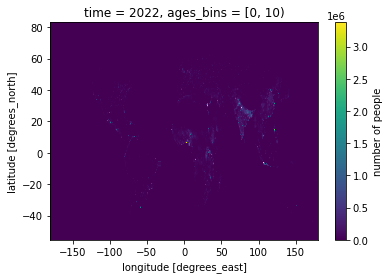

In [70]:
grouped_data.isel(ages_bins=0).plot()

In [71]:
grouped_data.ages_bins

<xarray.DataArray 'ages_bins' (ages_bins: 10)>
array([Interval(0, 10, closed='left'), Interval(10, 20, closed='left'),
       Interval(20, 30, closed='left'), Interval(30, 40, closed='left'),
       Interval(40, 50, closed='left'), Interval(50, 60, closed='left'),
       Interval(60, 70, closed='left'), Interval(70, 80, closed='left'),
       Interval(80, 90, closed='left'), Interval(90, 100, closed='left')],
      dtype=object)
Coordinates:
  * ages_bins  (ages_bins) object [0, 10) [10, 20) ... [80, 90) [90, 100)

In [72]:
x_hot_days = [1,5,10,20,50] 

df_out = pd.DataFrame()
df_out['age_ranges'] = age_ranges[:-1]
df_out = df_out.set_index('age_ranges')
for x in x_hot_days:
    df_out[f'n_atleast_{x}'] = np.nan
for x in x_hot_days:
    df_out[f'prop_atleast_{x}'] = np.nan
df_out

# make this and the following a function !! 

,n_atleast_1,n_atleast_5,n_atleast_10,n_atleast_20,n_atleast_50,prop_atleast_1,prop_atleast_5,prop_atleast_10,prop_atleast_20,prop_atleast_50
age_ranges,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:

for i in range(len(grouped_data.ages_bins)):
    
    for x in x_hot_days:
    
        # number of people living through at least 1 heatwave 
        n_people_at_least_x = grouped_data.isel(ages_bins=i).where(da_nAHD>=x).sum().values
        df_out.loc[age_ranges[i],f'n_atleast_{x}'] = n_people_at_least_x

        # proportion of people living through at least 1 heatwave
        prop_at_least_x = n_people_at_least_x / grouped_data.isel(ages_bins=i).sum().values
        df_out.loc[age_ranges[i],f'prop_atleast_{x}'] = prop_at_least_x

        print(i , x, n_people_at_least_x, prop_at_least_x)

0 1 1161833804.5199425 0.9604674953115996
0 5 1035547905.7814429 0.8560691722617223
0 10 751694962.833767 0.6214129554352296
0 20 367999918.27212363 0.3042190358058505
0 50 67565669.74666643 0.055855346382734324
1 1 1119554400.303308 0.9584789994423765
1 5 992706868.8213505 0.8498816012064144
1 10 713000947.9038192 0.6104182476199226
1 20 349175140.2352553 0.29893771928560936
1 50 66308317.47606766 0.05676823723076835
2 1 1042422939.8290061 0.956297795234572
2 5 916561309.4564263 0.8408348722393527
2 10 644520968.0180491 0.5912705459064592
2 20 316036725.9880623 0.28992572278303097
2 50 61447853.15116568 0.056371022015302724
3 1 1015599785.8631048 0.9451275602549206
3 5 868933837.8196951 0.8086387271769
3 10 577546605.9273858 0.5374707854332271
3 20 279489907.57070315 0.26009616990385803
3 50 56073852.254485324 0.0521829010926162
4 1 859771102.101619 0.9432629514213723
4 5 728146636.8826267 0.7988565143612767
4 10 469016604.96897894 0.5145625224984377
4 20 227610262.47001225 0.24971335

In [74]:
df_out

,n_atleast_1,n_atleast_5,n_atleast_10,n_atleast_20,n_atleast_50,prop_atleast_1,prop_atleast_5,prop_atleast_10,prop_atleast_20,prop_atleast_50
age_ranges,,,,,,,,,,
0,1.161834e+09,1.035548e+09,7.516950e+08,3.679999e+08,6.756567e+07,0.960467,0.856069,0.621413,0.304219,0.055855
10,1.119554e+09,9.927069e+08,7.130009e+08,3.491751e+08,6.630832e+07,0.958479,0.849882,0.610418,0.298938,0.056768
20,1.042423e+09,9.165613e+08,6.445210e+08,3.160367e+08,6.144785e+07,0.956298,0.840835,0.591271,0.289926,0.056371
30,1.015600e+09,8.689338e+08,5.775466e+08,2.794899e+08,5.607385e+07,0.945128,0.808639,0.537471,0.260096,0.052183
40,8.597711e+08,7.281466e+08,4.690166e+08,2.276103e+08,4.871035e+07,0.943263,0.798857,0.514563,0.249713,0.053441
50,7.348087e+08,6.044144e+08,3.607005e+08,1.723093e+08,3.831504e+07,0.930764,0.765597,0.456890,0.218260,0.048533
60,5.326613e+08,4.311058e+08,2.438817e+08,1.143770e+08,2.478972e+07,0.932770,0.754931,0.427073,0.200291,0.043411
70,2.955227e+08,2.357071e+08,1.230402e+08,5.508551e+07,1.141306e+07,0.934851,0.745631,0.389223,0.174256,0.036104
80,1.139900e+08,9.028849e+07,4.260857e+07,1.798588e+07,3.513145e+06,0.944977,0.748492,0.353225,0.149103,0.029124


#### plotting 

in plotscript, not in main

1. number of people experiencing at least n AHD per age group
2. proportion of age group experiencing at least n AHD


<AxesSubplot:xlabel='age_ranges'>

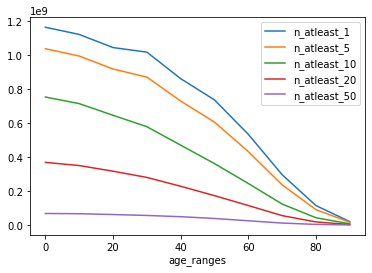

In [75]:
df_out.iloc[:,0:len(x_hot_days)].plot()

# this is just one model! 

Text(0.5, 1.0, 'number of people experiencing n attributable hot days in 2023 \n(CanESM5)')

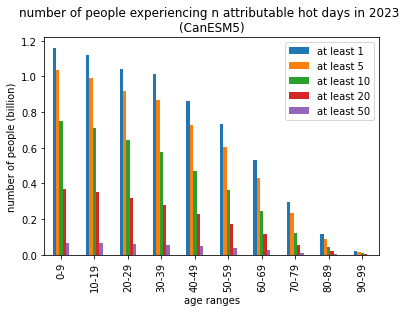

In [80]:
x_hot_days = [1,5,10,20,50] 

ax = (df_out.iloc[:,0:len(x_hot_days)]/1e9).plot.bar() #stacked=True
ax.set_ylabel('number of people (billion)')
ax.set_xlabel('age ranges')
ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+9}' for x in age_ranges[:-1]])
plt.legend(labels = [f'at least {x}' for x in x_hot_days])
ax.set_title(f'number of people experiencing n attributable hot days in 2023 \n({GCM})')

In [82]:
# proportion 

df_out.iloc[:,len(x_hot_days):]

,prop_atleast_1,prop_atleast_5,prop_atleast_10,prop_atleast_20,prop_atleast_50
age_ranges,,,,,
0,0.960467,0.856069,0.621413,0.304219,0.055855
10,0.958479,0.849882,0.610418,0.298938,0.056768
20,0.956298,0.840835,0.591271,0.289926,0.056371
30,0.945128,0.808639,0.537471,0.260096,0.052183
40,0.943263,0.798857,0.514563,0.249713,0.053441
50,0.930764,0.765597,0.456890,0.218260,0.048533
60,0.932770,0.754931,0.427073,0.200291,0.043411
70,0.934851,0.745631,0.389223,0.174256,0.036104
80,0.944977,0.748492,0.353225,0.149103,0.029124


<AxesSubplot:xlabel='age_ranges'>

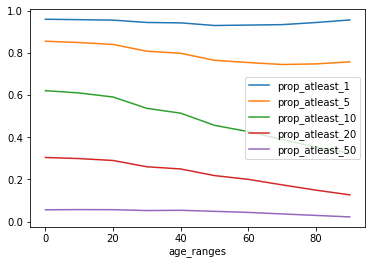

In [83]:
df_out.iloc[:,len(x_hot_days):].plot()

Text(0.5, 1.0, 'proportion of age group experiencing \nn attributable hot days in 2023 \n(CanESM5)')

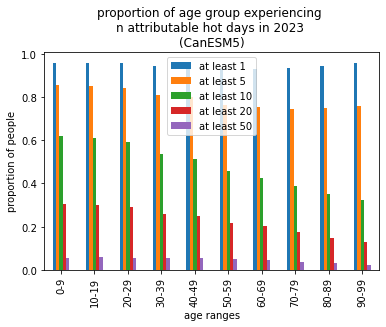

In [84]:
ax = df_out.iloc[:,len(x_hot_days):].plot.bar()
ax.set_ylabel('proportion of people')
ax.set_xlabel('age ranges')
ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+9}' for x in age_ranges[:-1]])
plt.legend(labels = [f'at least {x}' for x in x_hot_days])
ax.set_title(f'proportion of age group experiencing \nn attributable hot days in 2023 \n({GCM})')

# add a 'children' bar ? 
# make a 'children' bar and then compare with a line that is for rolling groups of 18 years ending from 18) to 100] ?
# can actually do this for each age.. doesn't need to be binned in 10-year groups 

### v2. do it for each age 

In [85]:
x_hot_days = [1,5,10,20,50] 

df_out = pd.DataFrame()
df_out['ages'] = gs_population_global.ages.values[0:100]
df_out = df_out.set_index('ages')
for x in x_hot_days:
    df_out[f'n_atleast_{x}'] = np.nan
for x in x_hot_days:
    df_out[f'prop_atleast_{x}'] = np.nan
df_out['n_people'] = np.nan
#df_out['n_people_whr_incr'] = np.nan
df_out

# make this and the following a function !! 

,n_atleast_1,n_atleast_5,n_atleast_10,n_atleast_20,n_atleast_50,prop_atleast_1,prop_atleast_5,prop_atleast_10,prop_atleast_20,prop_atleast_50,n_people
ages,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
# in calc_number_proportion_people_atleastxdays_1yr

for i in range(len(df_out)):
    
    for x in x_hot_days:
    
        # number of people living through at least 1 heatwave 
        n_people_at_least_x = gs_population_global.isel(ages=i).where(da_nAHD>=x).sum().values
        df_out.loc[i,f'n_atleast_{x}'] = n_people_at_least_x

        # proportion of people living through at least 1 heatwave
        prop_at_least_x = n_people_at_least_x / gs_population_global.isel(ages=i).sum().values
        df_out.loc[i,f'prop_atleast_{x}'] = prop_at_least_x
        
    n_people = gs_population_global.isel(ages=i).sum().values
    df_out.loc[i,f'n_people'] = n_people
    
    #n_people_whr_incr = gs_population_global.isel(ages=i).where(da_nAHD>0).sum().values - this is useful for per capita not for this 
    #df_out.loc[i,f'n_people'] = n_people

        #print(i, x, n_people_at_least_x, prop_at_least_x)

In [87]:
df_out

,n_atleast_1,n_atleast_5,n_atleast_10,n_atleast_20,n_atleast_50,prop_atleast_1,prop_atleast_5,prop_atleast_10,prop_atleast_20,prop_atleast_50,n_people
ages,,,,,,,,,,,
0,1.156317e+08,1.035821e+08,7.595325e+07,3.714498e+07,6.652366e+06,0.962982,0.862633,0.632540,0.309344,0.055401,1.200767e+08
1,1.157543e+08,1.035760e+08,7.577908e+07,3.706832e+07,6.675522e+06,0.962420,0.861166,0.630053,0.308199,0.055503,1.202742e+08
2,1.158769e+08,1.035699e+08,7.560491e+07,3.699165e+07,6.698677e+06,0.961860,0.859704,0.627574,0.307057,0.055604,1.204717e+08
3,1.159995e+08,1.035639e+08,7.543075e+07,3.691499e+07,6.721833e+06,0.961302,0.858246,0.625104,0.305919,0.055705,1.206692e+08
4,1.161221e+08,1.035578e+08,7.525658e+07,3.683832e+07,6.744989e+06,0.960745,0.856794,0.622641,0.304785,0.055805,1.208667e+08
...,...,...,...,...,...,...,...,...,...,...,...
95,1.411993e+06,1.122250e+06,4.774169e+05,1.850078e+05,3.101808e+04,0.960111,0.763094,0.324628,0.125799,0.021091,1.470657e+06
96,1.039207e+06,8.276862e+05,3.518198e+05,1.364367e+05,2.256495e+04,0.961708,0.765961,0.325583,0.126262,0.020882,1.080585e+06
97,6.664209e+05,5.331225e+05,2.262227e+05,8.786551e+04,1.411182e+04,0.965109,0.772067,0.327615,0.127247,0.020437,6.905136e+05


#### plotting

<AxesSubplot:xlabel='ages'>

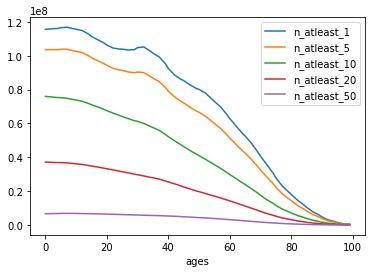

In [88]:
df_out.iloc[:,0:len(x_hot_days)].plot()

<AxesSubplot:xlabel='ages'>

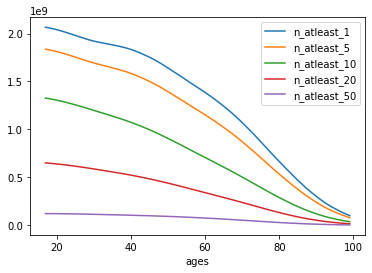

In [89]:
df_out.iloc[:,0:len(x_hot_days)].rolling(window=18).sum().plot()

In [90]:
# in calc_number_proportion_people_atleastxdays_1yr
size_win = 18

age_ranges = [i * size_win for i in range(df_out.index[-1] // size_win + 1)]
df_out_grouped_n = df_out.iloc[:,:len(x_hot_days)].groupby(by= ((df_out.index // size_win) + 1)).sum() # sum only good for n not for prop !!
df_out_grouped_n.index = age_ranges
df_out_grouped_n

,n_atleast_1,n_atleast_5,n_atleast_10,n_atleast_20,n_atleast_50
0,2.065344e+09,1.836729e+09,1.327367e+09,6.497686e+08,1.209284e+08
18,1.881773e+09,1.642234e+09,1.138595e+09,5.558697e+08,1.086630e+08
36,1.565445e+09,1.322186e+09,8.471814e+08,4.099997e+08,8.724636e+07
54,1.032721e+09,8.390509e+08,4.808477e+08,2.266395e+08,4.956928e+07
72,3.308813e+08,2.632122e+08,1.320204e+08,5.779218e+07,1.172996e+07
90,2.004722e+07,1.588169e+07,6.815850e+06,2.656368e+06,4.612475e+05


Text(0.5, 1.0, 'number of people experiencing \nn attributable hot days in 2023')

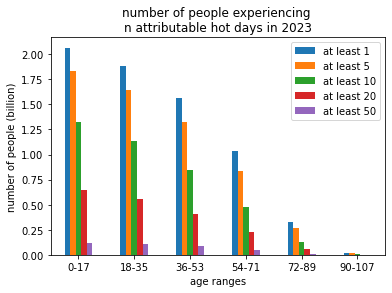

In [91]:
ax = (df_out_grouped_n.iloc[:,:len(x_hot_days)]/1e9).plot.bar()
ax.set_xticks(ticks=ax.get_xticks(), labels=[f'{x}-{x+size_win-1}' for x in df_out_grouped_n.index], rotation='horizontal')
ax.set_ylabel('number of people (billion)')
ax.set_xlabel('age ranges')
ax.legend(labels = [f'at least {x}' for x in x_hot_days])
ax.set_title('number of people experiencing \nn attributable hot days in 2023')

# note i only have data up to 99 in this table ! 

In [92]:
# proportion !! weighted mean
# in calc_number_proportion_people_atleastxdays_1yr

size_win = 18

age_ranges = [i * size_win for i in range(df_out.index[-1] // size_win + 1)]
df_out_weighted = df_out.iloc[:,len(x_hot_days):-1].multiply(df_out.iloc[:,-1], axis = 0) # proportion x number of people of each age 
sum_proportions_times_people = df_out_weighted.groupby(by= ((df_out_weighted.index // size_win) + 1)).sum()
sum_people_bracket = df_out.iloc[:,-1].groupby(by= ((df_out.index // size_win) + 1)).sum()
df_out_grouped_prop = sum_proportions_times_people.divide(sum_people_bracket, axis = 0)
df_out_grouped_prop.index = age_ranges

In [93]:
sum_proportions_times_people

,prop_atleast_1,prop_atleast_5,prop_atleast_10,prop_atleast_20,prop_atleast_50
ages,,,,,
1,2.065344e+09,1.836729e+09,1.327367e+09,6.497686e+08,1.209284e+08
2,1.881773e+09,1.642234e+09,1.138595e+09,5.558697e+08,1.086630e+08
3,1.565445e+09,1.322186e+09,8.471814e+08,4.099997e+08,8.724636e+07
4,1.032721e+09,8.390509e+08,4.808477e+08,2.266395e+08,4.956928e+07
5,3.308813e+08,2.632122e+08,1.320204e+08,5.779218e+07,1.172996e+07
6,2.004722e+07,1.588169e+07,6.815850e+06,2.656368e+06,4.612475e+05


In [94]:
sum_people_bracket #.sum()

ages
1    2.152405e+09
2    1.974817e+09
3    1.663085e+09
4    1.108455e+09
5    3.523241e+08
6    2.094769e+07
Name: n_people, dtype: float64

In [95]:
df_out_grouped_prop

,prop_atleast_1,prop_atleast_5,prop_atleast_10,prop_atleast_20,prop_atleast_50
0,0.959552,0.853338,0.616690,0.301880,0.056183
18,0.952885,0.831588,0.576557,0.281479,0.055024
36,0.941290,0.795020,0.509404,0.246530,0.052461
54,0.931677,0.756956,0.433800,0.204464,0.044719
72,0.939139,0.747074,0.374713,0.164031,0.033293
90,0.957013,0.758159,0.325375,0.126810,0.022019


<AxesSubplot:xlabel='ages'>

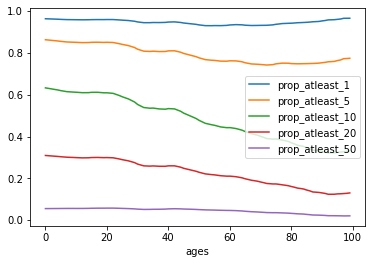

In [96]:
df_out.iloc[:,len(x_hot_days):-1].plot() # for each age

<AxesSubplot:>

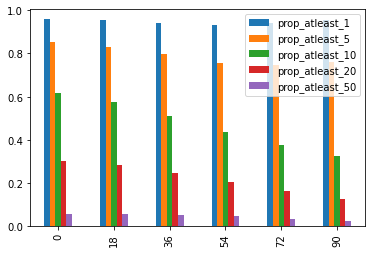

In [97]:
df_out_grouped_prop.plot.bar() # in 18-year brackets

## 6. CAHD vs. AAHD (people x heatwaves) for different age groups, and per capita 

### v1. divide in 10 year age groups first

In [98]:
df_people_times_hotdays = pd.DataFrame()
age_ranges = np.arange(0, 105, 10)
df_people_times_hotdays['age_ranges'] = age_ranges[:-1]
df_people_times_hotdays = df_people_times_hotdays.set_index('age_ranges')
df_people_times_hotdays['people_times_days'] = np.nan
df_people_times_hotdays['per_capita_days'] = np.nan
df_people_times_hotdays

,people_times_days,per_capita_days
age_ranges,,
0,NaN,NaN
10,NaN,NaN
20,NaN,NaN
30,NaN,NaN
40,NaN,NaN
50,NaN,NaN
60,NaN,NaN
70,NaN,NaN
80,NaN,NaN


In [99]:
for i in range(len(grouped_data.ages_bins)):
    
    people_times_hotdays = (grouped_data.isel(ages_bins=i).where(da_nAHD>0) * da_nAHD).sum().values
    df_people_times_hotdays.loc[age_ranges[i],f'people_times_days'] = people_times_hotdays
    
    per_capita_days = people_times_hotdays / grouped_data.isel(ages_bins=i).where(da_nAHD>0).sum().values
    df_people_times_hotdays.loc[age_ranges[i],f'per_capita_days'] = per_capita_days

    print(i, people_times_hotdays, per_capita_days)

0 21827495281.242657 18.486650240784932
1 20861379328.522224 18.309310501974526
2 19078154000.27965 17.95313990331914
3 17502653284.299377 16.8017770624959
4 14551638620.26555 16.479866392210706
5 11579898875.817162 15.243491361543576
6 7948425773.101219 14.439115101801201
7 4084880207.865374 13.386411073433102
8 1453368459.314311 12.402181836405429
9 236990932.35750952 11.560058069683729


In [100]:
df_people_times_hotdays

,people_times_days,per_capita_days
age_ranges,,
0,2.182750e+10,18.486650
10,2.086138e+10,18.309311
20,1.907815e+10,17.953140
30,1.750265e+10,16.801777
40,1.455164e+10,16.479866
50,1.157990e+10,15.243491
60,7.948426e+09,14.439115
70,4.084880e+09,13.386411
80,1.453368e+09,12.402182


Text(0.5, 0, 'age group')

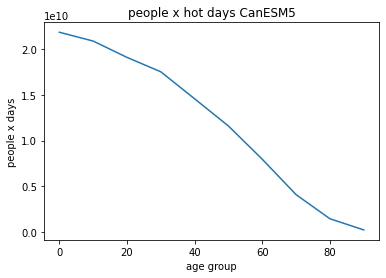

In [103]:
df_people_times_hotdays['people_times_days'].plot()
plt.title(f'people x hot days {GCM}')
plt.ylabel('people x days')
plt.xlabel('age group')


Text(0.5, 0, 'age group')

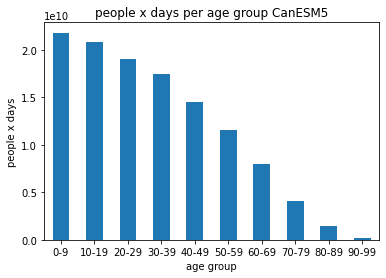

In [104]:
fig = df_people_times_hotdays['people_times_days'].plot.bar()
fig.set_xticks(ticks=fig.get_xticks(), labels=[f'{x}-{x+9}' for x in age_ranges[:-1]], rotation='horizontal')
fig.set_title(f'people x days per age group {GCM}')
plt.ylabel('people x days')
plt.xlabel('age group')


Text(0.5, 0, 'age group')

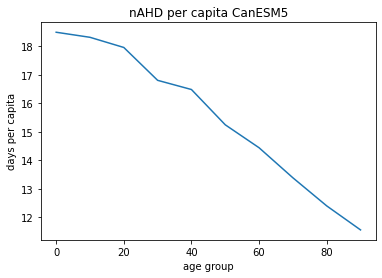

In [107]:
df_people_times_hotdays['per_capita_days'].plot()
plt.title(f'nAHD per capita {GCM}')
plt.ylabel('days per capita')
plt.xlabel('age group')


Text(0.5, 1.0, 'nAHD per capita CanESM5')

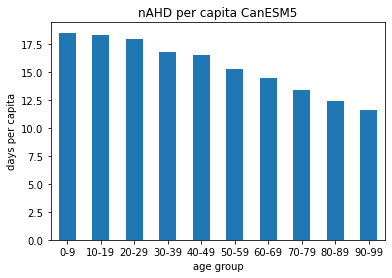

In [110]:
fig = df_people_times_hotdays['per_capita_days'].plot.bar()
fig.set_xticks(ticks=fig.get_xticks(), labels=[f'{x}-{x+9}' for x in age_ranges[:-1]], rotation='horizontal')
plt.ylabel('days per capita')
plt.xlabel('age group')
plt.title(f'nAHD per capita {GCM}')

In [1]:
df_people_times_hotdays

NameError: name 'df_people_times_hotdays' is not defined

#### Note: bar plot of total n of people of each age in world 

In [108]:
# make empty dataframe
df_n_people = pd.DataFrame(index=age_ranges[:-1], columns=['n_people']).fillna(np.nan)
df_n_people.index.name = 'age_ranges'

for i in range(len(grouped_data.ages_bins)):
    
    n_people = grouped_data.isel(ages_bins=i).sum().values
    
    df_n_people.loc[age_ranges[i],f'n_people'] = n_people

Text(0.5, 1.0, 'total number of people of each age in world')

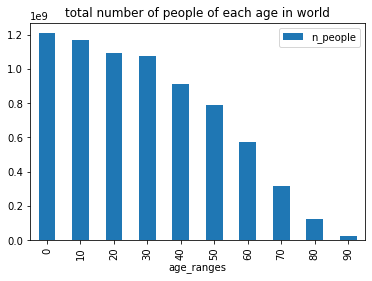

In [109]:
df_n_people.plot.bar()
plt.title('total number of people of each age in world')

### v2. do it for each age